In [6]:
from pathlib import Path
from urllib.request import urlretrieve
from skimage import io
import matplotlib.pyplot as plt
import numpy as np

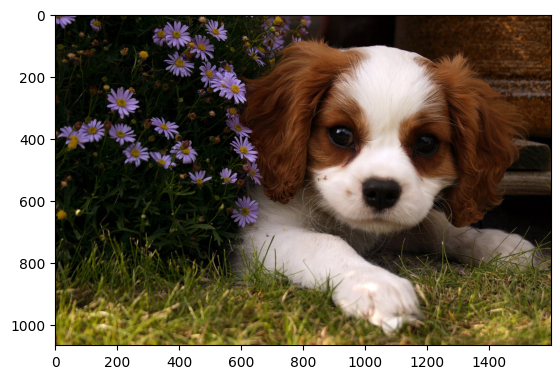

In [5]:
url = 'https://upload.wikimedia.org/wikipedia/commons/thumb/4/43/Cute_dog.jpg/1600px-Cute_dog.jpg?20140729055059'
path_img = Path('puppy.jpg')
if not path_img.exists(): urlretrieve(url, path_img)
img = io.imread('puppy.jpg')
plt.imshow(img)
plt.show()


Convert RGB image to grayscale image.

In [124]:
def rgb2gray(rgb):
    gray = np.zeros(rgb.shape[:2], dtype=rgb.dtype)
    for i in range(rgb.shape[0]):
        for j in range(rgb.shape[1]):
            gray[i, j] = 0.2989 * rgb[i, j, 0] + 0.5870 * rgb[i, j, 1] + 0.1140 * rgb[i, j, 2]
    return gray

def rgb2gray2_np(rgb):
    return np.dot(rgb[...,:3], [0.2989, 0.5870, 0.1140]).astype(np.uint8)

In [125]:
%%time 

# gray = rgb2gray(img) # too slow
gray = rgb2gray2_np(img)

CPU times: user 52.3 ms, sys: 16 ms, total: 68.4 ms
Wall time: 66 ms


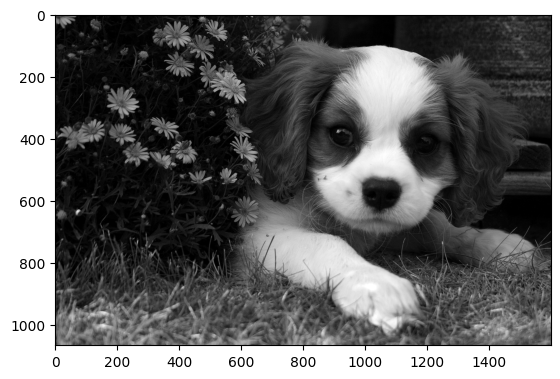

In [126]:
plt.imshow(gray, cmap='gray')
plt.show()

Using numba

In [202]:
from numba import cuda

In [203]:
@cuda.jit 
def rgb2gray3(out, x, h, w):
    r = cuda.blockIdx.y*cuda.blockDim.y + cuda.threadIdx.y
    c = cuda.blockIdx.x*cuda.blockDim.x + cuda.threadIdx.x
    if (r>=h or c>=w): return
    i = r*w + c
    offset = i*3
    out[i] = 0.2989*x[offset] + 0.5870*x[offset+1] + 0.1140*x[offset+2]

In [237]:
%%time 

img_c = cuda.to_device(img.flatten())
output_c = cuda.device_array(h*w, dtype=img.dtype)
threads_per_block = (16, 16)
blocks = (math.ceil(w / threads_per_block[0]), math.ceil(h / threads_per_block[1]))

rgb2gray3[blocks, threads_per_block](output_c, img_c, h, w)

CPU times: user 6.79 ms, sys: 77 µs, total: 6.87 ms
Wall time: 4.86 ms


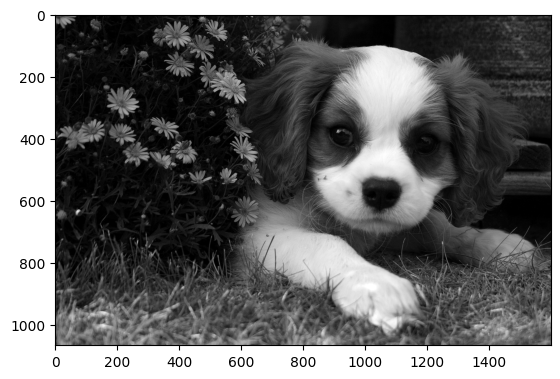

In [228]:
plt.imshow(output_c.reshape(h, w), cmap='gray')
plt.show()

Let's implement in CUDA with Pytorch.

In [108]:
import torch
from torch.utils.cpp_extension import load_inline

%load_ext wurlitzer

The wurlitzer extension is already loaded. To reload it, use:
  %reload_ext wurlitzer


In [109]:
def load_cuda(cuda_src, cpp_src, funcs, opt=False, verbose=False):
    return load_inline(cuda_sources=[cuda_src], cpp_sources=[cpp_src], functions=funcs,
                       extra_cuda_cflags=["-O2"] if opt else [], verbose=verbose, name="inline_ext")

In [170]:
cuda_begin = r'''
#include <torch/extension.h>
#include <stdio.h>
#include <c10/cuda/CUDAException.h>

#define CHECK_CUDA(x) TORCH_CHECK(x.device().is_cuda(), #x " must be a CUDA tensor")
#define CHECK_CONTIGUOUS(x) TORCH_CHECK(x.is_contiguous(), #x " must be contiguous")
#define CHECK_INPUT(x) CHECK_CUDA(x); CHECK_CONTIGUOUS(x)

inline unsigned int cdiv(unsigned int a, unsigned int b) { return (a + b - 1) / b;}
'''

In [185]:
cuda_src = cuda_begin + r'''
# define CHANNELS 3

__global__ void rgb_to_grayscale_kernel(unsigned char* x, unsigned char* out, int h, int w) {
    int c = blockIdx.x*blockDim.x + threadIdx.x;
    int r = blockIdx.y*blockDim.y + threadIdx.y;

    if (c<w && r<h) {
        int i = r*w + c;
		int offset = i*CHANNELS;
        out[i] = 0.2989*x[offset] + 0.5870*x[offset+1] + 0.1140*x[offset+2];
    }
}

torch::Tensor rgb_to_grayscale(torch::Tensor input) {
    CHECK_INPUT(input);
    int h = input.size(0);
    int w = input.size(1);
    torch::Tensor output = torch::empty({h,w}, input.options());
    dim3 tpb(16,16);
    dim3 blocks(cdiv(w, tpb.x), cdiv(h, tpb.y));
    rgb_to_grayscale_kernel<<<blocks, tpb>>>(
        input.data_ptr<unsigned char>(), output.data_ptr<unsigned char>(), h, w);
    C10_CUDA_KERNEL_LAUNCH_CHECK();
    return output;
}'''

In [186]:
cpp_src = "torch::Tensor rgb_to_grayscale(torch::Tensor input);"

In [187]:
module = load_cuda(cuda_src, cpp_src, ['rgb_to_grayscale'], verbose=True)

Using /home/juan/.cache/torch_extensions/py38_cu121 as PyTorch extensions root...
The input conditions for extension module inline_ext have changed. Bumping to version 5 and re-building as inline_ext_v5...
Detected CUDA files, patching ldflags
Emitting ninja build file /home/juan/.cache/torch_extensions/py38_cu121/inline_ext/build.ninja...
Building extension module inline_ext_v5...
Allowing ninja to set a default number of workers... (overridable by setting the environment variable MAX_JOBS=N)


[1/3] c++ -MMD -MF main.o.d -DTORCH_EXTENSION_NAME=inline_ext_v5 -DTORCH_API_INCLUDE_EXTENSION_H -DPYBIND11_COMPILER_TYPE=\"_gcc\" -DPYBIND11_STDLIB=\"_libstdcpp\" -DPYBIND11_BUILD_ABI=\"_cxxabi1011\" -isystem /home/juan/miniconda3/envs/cuda/lib/python3.8/site-packages/torch/include -isystem /home/juan/miniconda3/envs/cuda/lib/python3.8/site-packages/torch/include/torch/csrc/api/include -isystem /home/juan/miniconda3/envs/cuda/lib/python3.8/site-packages/torch/include/TH -isystem /home/juan/miniconda3/envs/cuda/lib/python3.8/site-packages/torch/include/THC -isystem /home/juan/miniconda3/envs/cuda/include -isystem /home/juan/miniconda3/envs/cuda/include/python3.8 -D_GLIBCXX_USE_CXX11_ABI=0 -fPIC -std=c++17 -c /home/juan/.cache/torch_extensions/py38_cu121/inline_ext/main.cpp -o main.o 
[2/3] /home/juan/miniconda3/envs/cuda/bin/nvcc --generate-dependencies-with-compile --dependency-output cuda.cuda.o.d -DTORCH_EXTENSION_NAME=inline_ext_v5 -DTORCH_API_INCLUDE_EXTENSION_H -DPYBIND11_COMPILE

Loading extension module inline_ext_v5...


In [192]:
dir(module)

['__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__spec__',
 'rgb_to_grayscale']

In [233]:
%%time 

img_t = torch.from_numpy(img).cuda()

gray_t = module.rgb_to_grayscale(img_t).cpu().numpy()

CPU times: user 4 ms, sys: 0 ns, total: 4 ms
Wall time: 2.12 ms


Nice speedup !

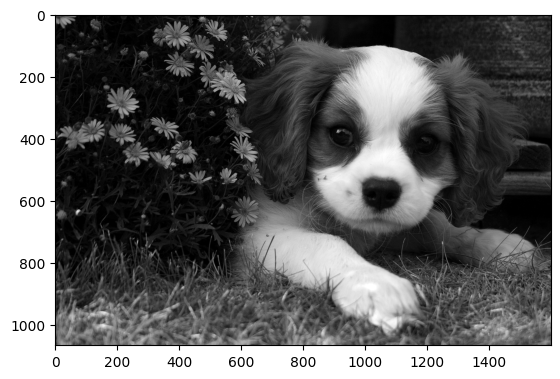

In [197]:
plt.imshow(gray_t, cmap='gray')
plt.show()